In [1]:
from pathlib import Path
import logging
import re
from unionfind import UnionFind
from tqdm import tqdm
from collections import Counter
from pprint import pprint
import numpy as np

from paths import data_path
from load_urls import load_urls

from collections import namedtuple
from auxiliary_functions import tokenize

import matplotlib.pyplot as plt

%matplotlib inline

# global functions and variables
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)
_info = logging.info

In [2]:
from gen_model import gen_model

2018-06-01 12:22:29,776 : loading short urls
2018-06-01 12:22:37,579 : loaded 1532034 urls
2018-06-01 12:22:37,579 : loading expanded urls
2018-06-01 12:22:42,245 : loaded 2214565 urls
2018-06-01 12:22:42,246 : cleaning url residual info


In [3]:
import spacy

_info("loading spacy")
nlp = spacy.load('en_core_web_sm', parser=False, tagger=False, entity=False, matcher=False)

2018-06-01 12:22:49,917 : loading spacy


# functions

In [4]:
def urls_from_component(comp):
    return [e for e in comp if not e.isnumeric()]

def tweet_ids_from_component(comp):
    return [e for e in comp if e.isnumeric()]

def tokens_per_component(comp, event, name):
    tokens_per_component = dict()

    for i, component in tqdm(enumerate(comp), total=len(comp), desc=name):
        for elem in component:
            if elem.isnumeric():
                tweet = event.get(elem)
                tokens = tokenize(nlp, tweet.text, allow_stop=False)
                counter = tokens_per_component.get(i)
                if not counter:
                    counter = Counter()
                counter.update(tokens)
                tokens_per_component[i] = counter
                
    return tokens_per_component

# Models

In [5]:
# libya:
l_name = 'libya_hotel_tweets.tsv'
l_uf, l_event = gen_model(l_name)
l_components = l_uf.components()
l_tokens_per_component = tokens_per_component(l_components, l_event, l_name)

# oscar:
o_name = 'oscar_pistorius_tweets.tsv'
o_uf, o_event = gen_model(o_name)
o_components = o_uf.components()
o_tokens_per_component = tokens_per_component(o_components, o_event, o_name)

# nepal
n_name = 'nepal_tweets.tsv'
n_uf, n_event = gen_model(n_name)
n_components = n_uf.components()
n_tokens_per_component = tokens_per_component(n_components, n_event, n_name)

2018-06-01 12:22:56,874 : load and clean dataset: libya_hotel_tweets.tsv
2018-06-01 12:22:57,003 : tweets processed: 26331, ignored: 2309, missing urls: 6341
2018-06-01 12:22:57,003 : create pairs (t, u) or (t, t') for each tweet t and url u or replied/retweeted tweet t'
2018-06-01 12:22:57,021 : total pairs: 20108, retweets: 11323, quotes: 0, replies: 289 (missing: 0)
2018-06-01 12:22:57,021 : applying union-find
2018-06-01 12:22:57,155 : total components: 2747
libya_hotel_tweets.tsv: 100%|██████████| 2747/2747 [01:41<00:00, 27.04it/s]
2018-06-01 12:24:38,848 : load and clean dataset: oscar_pistorius_tweets.tsv
2018-06-01 12:24:39,330 : tweets processed: 112260, ignored: 955, missing urls: 21807
2018-06-01 12:24:39,330 : create pairs (t, u) or (t, t') for each tweet t and url u or replied/retweeted tweet t'
2018-06-01 12:24:39,398 : total pairs: 66804, retweets: 26179, quotes: 0, replies: 1553 (missing: 0)
2018-06-01 12:24:39,399 : applying union-find
2018-06-01 12:24:40,061 : total c

# Libya Hotel

In [6]:
l_f_tweets = list()
l_f_vocab = list()

for comp_id, counter in l_tokens_per_component.items():
    comp = l_components[comp_id]
    total_tweets = sum(1 for e in tweet_ids_from_component(comp))
   
    l_f_tweets.append(total_tweets)
    l_f_vocab.append(len(counter))

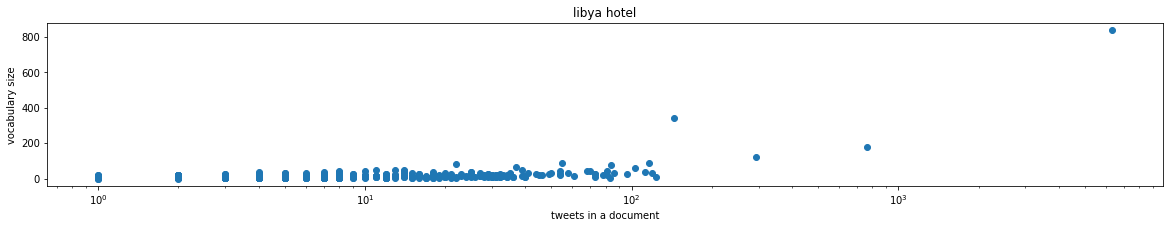

In [7]:
plt.figure(figsize=(20, 3))
plt.scatter(l_f_tweets, l_f_vocab)
plt.ylabel('vocabulary size')
plt.xlabel('tweets in a document')
plt.title('libya hotel')

plt.xscale('log')
plt.show()

largest component:

In [8]:
largest = max(l_components, key=lambda c: len(c))
print(len(largest))
pprint(urls_from_component(largest))

6470
['https://twitter.com/DoyleGlobal/status/560140996327907329/photo/1',
 'https://twitter.com/SputnikInt/status/560021523717963776/photo/1',
 'http://www.top5stories.com/',
 'http://linkaloo.blogspot.cl/search/label/NZ',
 'https://twitter.com/DoyleGlobal/status/560157572355743744/photo/1',
 'https://twitter.com/SputnikInt/status/560024724890480640/photo/1',
 'https://twitter.com/dlb703/status/560097043172302848/photo/1',
 'http://www.telegraph.co.uk/',
 'http://www.duduradio.com',
 'https://twitter.com/MiddleEastEye/status/560082588145303552/photo/1',
 'https://twitter.com/charliewinter/status/560048397135409154/photo/1',
 'http://www.nbcnews.com/',
 'https://twitter.com/DoyleGlobal/status/560074041810100224/photo/1',
 'http://www.middleeasteye.net/news/gunmen-kill-guards-and-take-hostages-corinthia-hotel-libyas-tripoli-705958223',
 'https://twitter.com/allinonesgnews/status/560011724842348544/photo/1',
 'https://twitter.com/LovegirlMckee/status/560062124618428417/photo/1',
 'https:

**otra idea: graficar el promedio de frecuencia de las palabras de todos los documentos de tamaño fijo, para ver la diversidad de contenido dado el tamaño de un documento**

## Distribucion de tamaños de documentos

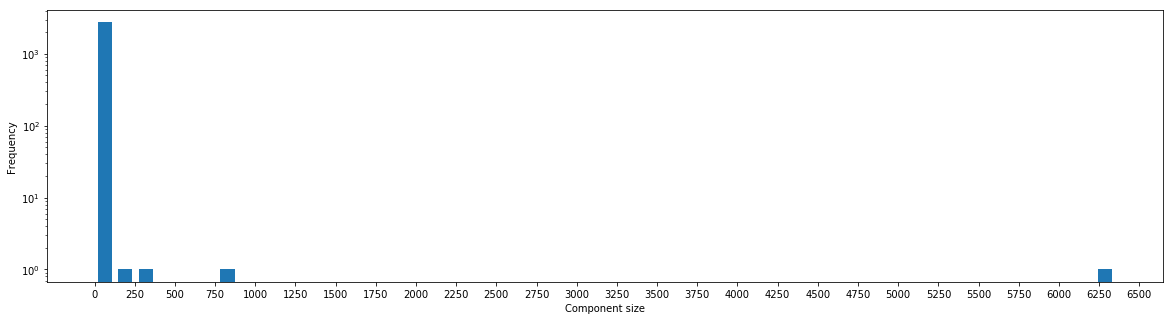

In [9]:
sizes = [len(tweet_ids_from_component(comp)) for comp in l_components]

hist, bins = np.histogram(sizes, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(20, 5))
plt.bar(center, hist, align='center', width=width)

plt.xlabel('Component size')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xticks(np.arange(0, max(sizes)+251, 250))
plt.show()

# Oscar Pistorius

In [10]:
o_f_tweets = list()
o_f_vocab = list()

for comp_id, counter in o_tokens_per_component.items():
    comp = o_components[comp_id]
    total_tweets = sum(1 for e in tweet_ids_from_component(comp))
   
    o_f_tweets.append(total_tweets)
    o_f_vocab.append(len(counter))


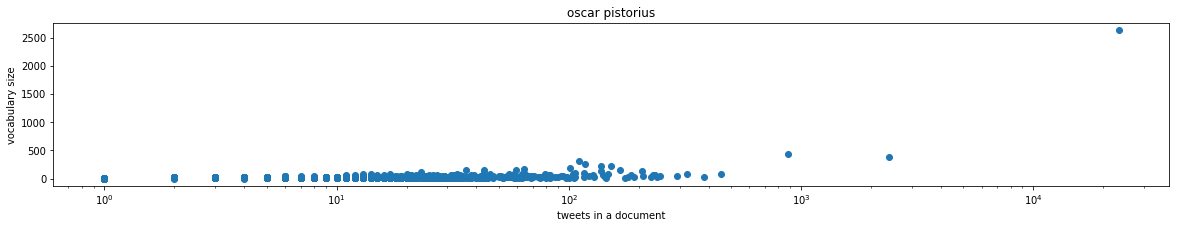

In [11]:
plt.figure(figsize=(20, 3))
plt.scatter(o_f_tweets, o_f_vocab)
plt.ylabel('vocabulary size')
plt.xlabel('tweets in a document')
plt.title('oscar pistorius')

plt.xscale('log')
plt.show()

In [12]:
largest = max(o_components, key=lambda c: len(c))
print(len(largest))
pprint(urls_from_component(largest))

23760
['https://www.yahoo.com/news/pistorius-takes-prosthetics-off-during-testimony-113602209--spt.html',
 'http://www.foxnews.com/world/2014/03/07/oscar-pistorius-court-hears-more-testimony-from-man-who-saw-runner-with.html',
 'https://www.popsugar.com/celebrity/Oscar-Pistorius-Ex-Girlfriend-Samantha-Taylor-Testimony-34293710',
 'http://www.telegraph.co.uk/news/worldnews/oscar-pistorius/10769304/Oscar-Pistorius-murder-trial-April-15-as-it-happened.html',
 'http://edition.cnn.com/2013/02/22/world/africa/pistorius-legal-q-and-a/index.html',
 'http://www.telegraph.co.uk/',
 'http://www.telegraph.co.uk/news/worldnews/oscar-pistorius/10687571/Oscar-Pistorius-sobs-and-vomits-as-court-hears-graphic-evidence-of-injuries-to-Reeva-Steenkamp.html',
 'http://edition.cnn.com/2014/05/05/world/africa/oscar-pistorius-trial/index.html',
 'http://au.news-you-need-to-know.com/2014/04/au-news-oscar-pistorius-oscar-pistorius_9252.html',
 'http://abcnews.go.com/International/oscar-pistorius-undergo-psychia

## Distribucion de tamaños de documentos

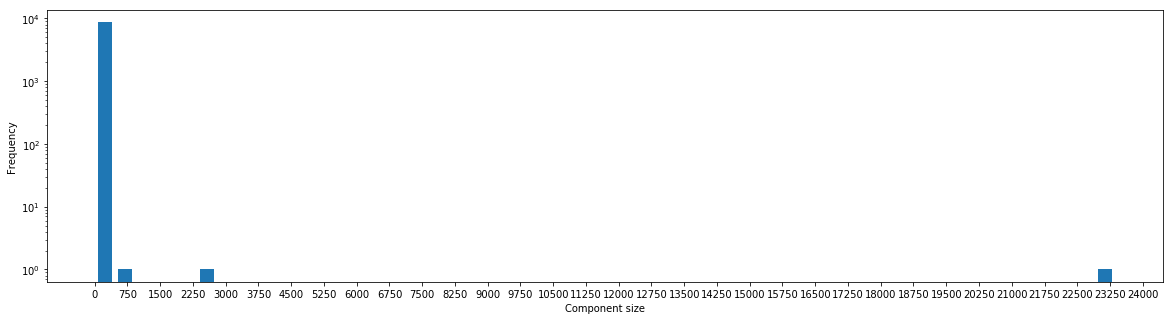

In [13]:
sizes = [len(tweet_ids_from_component(comp)) for comp in o_components]

hist, bins = np.histogram(sizes, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(20, 5))
plt.bar(center, hist, align='center', width=width)

plt.xlabel('Component size')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xticks(np.arange(0, max(sizes)+750, 750))
plt.show()

# Nepal Earthquake

In [14]:
n_f_tweets = list()
n_f_vocab = list()

for comp_id, counter in n_tokens_per_component.items():
    comp = n_components[comp_id]
    total_tweets = sum(1 for e in tweet_ids_from_component(comp))
   
    n_f_tweets.append(total_tweets)
    n_f_vocab.append(len(counter))


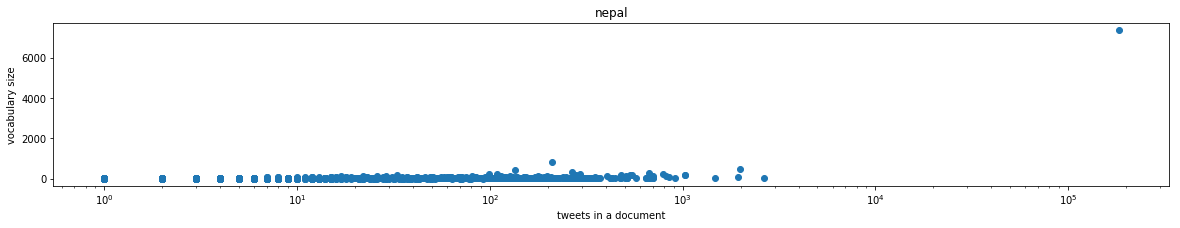

In [15]:
plt.figure(figsize=(20, 3))
plt.scatter(n_f_tweets, n_f_vocab)
plt.ylabel('vocabulary size')
plt.xlabel('tweets in a document')
plt.title('nepal')

plt.xscale('log')
plt.show()

In [16]:
largest = max(n_components, key=lambda c: len(c))
print(len(largest))
pprint(urls_from_component(largest))

185411
['https://twitter.com/LastQuake/status/591884972014862337/photo/1',
 'https://twitter.com/MollyTetsuya/status/591874251608686592/photo/1',
 'https://www.usatoday.com/story/tech/2015/04/25/google-dan-fredinburg-everest-nepal/26369109/',
 'https://twitter.com/mashable/status/592089438462865408',
 'https://twitter.com/MPGAnnapolis/status/591927710978580480/photo/1',
 'https://twitter.com/EdJoyce/status/592097704123105280/photo/1',
 'https://twitter.com/worldnews_net/status/591897056316420096/photo/1',
 'https://twitter.com/presstimes/status/591975903573442561/photo/1',
 'https://twitter.com/ReutersIndia/status/592058288663048196/photo/1',
 'http://hosted2.ap.org/APDEFAULT/3d281c11a96b4ad082fe88aa0db04305/Article_2015-04-25-AS-Nepal-Earthquake-Things-to-Know/id-77f79de3ce224064b23a18c7eda2ad49',
 'https://twitter.com/SkanndTyagi/status/591945780841308160/photo/1',
 'http://ireport.cnn.com/topics/1236496',
 'http://tweetedtimes.com/westbase',
 'https://twitter.com/EdJoyce/status/5919

## Distribucion de tamaños de documentos

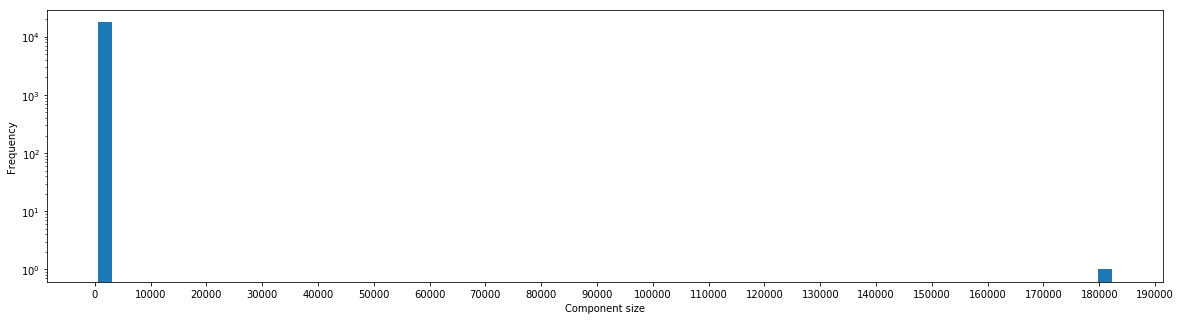

In [17]:
sizes = [len(tweet_ids_from_component(comp)) for comp in n_components]

hist, bins = np.histogram(sizes, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(20, 5))
plt.bar(center, hist, align='center', width=width)

plt.xlabel('Component size')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xticks(np.arange(0, max(sizes)+10000, 10000))
plt.show()